# Train a Model to Predict Formation Energy using the OQMD
This notebook recreates a 2016 paper by [Ward *et al.*](https://www.nature.com/articles/npjcompumats201628) on predicting the formation enthalpy of materials based on their composition. We will use the [Materials Data Facility](http://materialsdatafacility.org) to retrieve a training set from the the [OQMD](http://oqmd.org), compute features based on the composition of each entry, and then train a random forest model.

In [1]:
%matplotlib inline
from matminer.data_retrieval import retrieve_MDF
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

Settings to change

In [2]:
quick_demo = True # Whether to run an faster version of this demo. 
# The full OQMD model takes about a hour to test and ~8GB of RAM

## Load Training Set
Ward _et al._ trained their machine learning models on the formation enthalpies of crystalline compounds form the [OQMD](oqmd.org). Here, we extract the data using the copy of the OQMD available through the MDF

### Download the Data
We first create a `Forge` instance, which simplifies performing search queries against the MDF.

The first step is to create a tool for reading from the MDF's search index.

In [3]:
mdf = retrieve_MDF.MDFDataRetrieval(anonymous=True)

Then, we assemble a query that gets only the converged static calculations from the OQMD. 

In [4]:
query_string = 'mdf.source_name:oqmd AND (oqmd.configuration:static OR oqmd.configuration:standard) AND oqmd.converged:True'
if quick_demo:
    query_string += " AND mdf.scroll_id:<10000"

In [5]:
data = mdf.get_dataframe_by_query(query_string, unwind_arrays=False)

This tool creates a DataFrame object with the metadata for each entry in the OQMD

In [6]:
data.head(2)

,mdf.collection,mdf.composition,mdf.elements,mdf.ingest_date,mdf.links.landing_page,mdf.links.metadata.globus_endpoint,mdf.links.metadata.http_host,mdf.links.metadata.path,mdf.links.outcar.globus_endpoint,mdf.links.outcar.http_host,...,oqmd.delta_e.value,oqmd.magnetic_moment.units,oqmd.magnetic_moment.value,oqmd.spacegroup,oqmd.stability.units,oqmd.stability.value,oqmd.total_energy.units,oqmd.total_energy.value,oqmd.volume.units,oqmd.volume.value
0,OQMD,Ge2Nd1,"[Nd, Ge]",2017-08-04T14:19:23.147952Z,http://oqmd.org/analysis/calculation/29796,82f1b5c6-6e9b-11e5-ba47-22000b92c6ec,https://data.materialsdatafacility.org,/collections/oqmd/data/home/oqmd/libraries/ics...,82f1b5c6-6e9b-11e5-ba47-22000b92c6ec,https://data.materialsdatafacility.org,...,-0.611078,bohr/atom,0.000235,141,eV/atom,0.054520,eV/atom,-5.281178,angstrom^3/atom,23.2976
1,OQMD,Ho1Mn2,"[Ho, Mn]",2017-08-04T14:19:23.161706Z,http://oqmd.org/analysis/calculation/26724,82f1b5c6-6e9b-11e5-ba47-22000b92c6ec,https://data.materialsdatafacility.org,/collections/oqmd/data/home/oqmd/libraries/ics...,82f1b5c6-6e9b-11e5-ba47-22000b92c6ec,https://data.materialsdatafacility.org,...,0.130987,bohr/atom,0.673198,227,eV/atom,0.132414,eV/atom,-7.412546,angstrom^3/atom,15.3350


We only need two columns: `oqmd.delta_e.value` and `mdf.composition`

In [7]:
data = data[['oqmd.delta_e.value', 'mdf.composition']]

### Compile the Training Set
Our next step is to get only the lowest-energy entry for each composition.

In [8]:
data['composition_obj'] = str_to_composition(data['mdf.composition'])

Create shortcuts for our input and output columns

Remove compounds w/o a `delta_e` measurement.

In [9]:
for k in ['oqmd.delta_e.value']:
    data[k] = pd.to_numeric(data[k])

In [10]:
original_count = len(data)
data = data[~ data['oqmd.delta_e.value'].isnull()]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 1/6847 entries


Get only the groundstate and each composition

In [11]:
%%time
original_count = len(data)
data['mdf.composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
data.sort_values('oqmd.delta_e.value', ascending=True, inplace=True)
data.drop_duplicates('mdf.composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

c:\users\logan\miniconda3\lib\site-packages\pymatgen\core\periodic_table.py:409: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
c:\users\logan\miniconda3\lib\site-packages\pymatgen\core\periodic_table.py:409: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Removed 1014/6846 entries
Wall time: 563 ms


Remove outliers

In [12]:
original_count = len(data)
data = data[np.logical_and(data['oqmd.delta_e.value'] >= -20, data['oqmd.delta_e.value'] <= 5)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/5832 entries


## Build an ML model
In this part of the notebook, we build a ML model using [scikit-learn](http://scikit-learn.org/stable/) and evaluate its performance using cross-validation.

### Part 1: Compute Representation
The first step in building a ML model is to convert the raw materials data (here: the composition) into the required input for an ML model: a finite list of quantitative attributes. In this example, we use the "general-purpose" attributes of [Ward *et al* 2016](https://www.nature.com/articles/npjcompumats201628).

In [13]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

In [14]:
feature_calculators.set_n_jobs(None)

Get the feature names

In [15]:
feature_labels = feature_calculators.feature_labels()

Compute the features

In [16]:
%%time
feature_calculators.featurize_dataframe(data, col_id='composition_obj');

Wall time: 8.44 s


,oqmd.delta_e.value,mdf.composition,composition_obj,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,...,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
5778,-4.566378,EuF2,"(Eu, F)",2.0,0.745356,0.693361,0.670782,0.667408,0.666732,9.0,...,86.333333,95.111111,15.0,2.0,3.333333,0.000000,2.333333,1.0,0.855156,0.190035
4361,-4.445824,LaF3,"(F, La)",2.0,0.790569,0.759147,0.750616,0.750049,0.750001,9.0,...,59.750000,67.125000,15.0,2.0,3.750000,0.250000,0.000000,1.0,0.874268,0.163925
3174,-4.267783,ScF3,"(F, Sc)",2.0,0.790569,0.759147,0.750616,0.750049,0.750001,9.0,...,59.750000,67.125000,15.0,2.0,3.750000,0.250000,0.000000,1.0,0.820234,0.153794
3098,-4.219407,CaF2,"(Ca, F)",2.0,0.745356,0.693361,0.670782,0.667408,0.666732,9.0,...,85.000000,93.333333,15.0,2.0,3.333333,0.000000,0.000000,1.0,0.891402,0.198089
1180,-4.205988,SrF2,"(F, Sr)",2.0,0.745356,0.693361,0.670782,0.667408,0.666732,9.0,...,85.000000,93.333333,15.0,2.0,3.333333,0.000000,0.000000,1.0,0.899261,0.199836
348,-4.127525,YOF,"(F, O, Y)",3.0,0.577350,0.480750,0.415244,0.389977,0.372041,8.0,...,73.666667,80.222222,12.0,2.0,3.000000,0.333333,0.000000,1.0,0.851088,0.181079
3562,-4.103321,SmOF,"(F, O, Sm)",3.0,0.577350,0.480750,0.415244,0.389977,0.372041,8.0,...,64.333333,67.777778,12.0,2.0,3.000000,0.000000,2.000000,1.0,0.861103,0.183961
3736,-4.057366,NdOF,"(F, Nd, O)",3.0,0.577350,0.480750,0.415244,0.389977,0.372041,8.0,...,73.666667,80.222222,12.0,2.0,3.000000,0.000000,1.333333,1.0,0.866866,0.185634
634,-4.009212,PuOF,"(F, O, Pu)",3.0,0.577350,0.480750,0.415244,0.389977,0.372041,8.0,...,12.666667,1.555556,11.0,2.0,3.000000,0.000000,2.000000,0.0,0.838379,0.177467
786,-3.965715,BaF2,"(Ba, F)",2.0,0.745356,0.693361,0.670782,0.667408,0.666732,9.0,...,86.333333,95.111111,15.0,2.0,3.333333,0.000000,0.000000,1.0,0.908097,0.201799


In [17]:
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

Generated 145 features
Training set size: 5832x145


Remove entries with `NaN` or `infinite` features

In [18]:
original_count = len(data)
data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 2/5832 entries


### Part 2: Tuning Model Hyper-parameters
For brevity, we will only consider one ML algorithm in this example: [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). The "random forest" algorithm works by training many different decision tree models, where each is trained on a different subset of the dataset . Here, we tune one of the major parameters of the algoritm: the number features considered at each split in each decision tree

In [19]:
model = GridSearchCV(RandomForestRegressor(n_estimators=20 if quick_demo else 150, n_jobs=-1),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))

In [20]:
model.fit(data[feature_labels], data['oqmd.delta_e.value'])

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(8, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Plot the tuning results. This shows the CV score as a function of the parameter we tuned "max features"

In [21]:
model.best_score_

-0.04602061521543504

Text(0,0.5,'RMSE (eV/atom)')

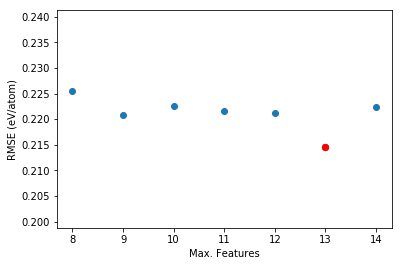

In [22]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

Save our best model

In [23]:
model = model.best_estimator_

### Part 3: Cross-validation Test
Quantify the performance of this model using 10-fold cross-validation

In [24]:
cv_prediction = cross_val_predict(model, data[feature_labels], data['oqmd.delta_e.value'], cv=KFold(10, shuffle=True))

Compute aggregate statistics

In [25]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['oqmd.delta_e.value'], cv_prediction)
    print(scorer, score)

r2_score 0.9294058204186414
mean_absolute_error 0.1237147626385269
mean_squared_error 0.047162460036018025


In [26]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Plot the individual predictions

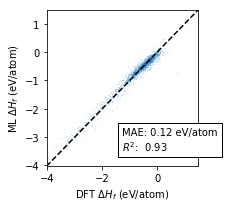

In [27]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(data['oqmd.delta_e.value']), cv_prediction, norm=LogNorm(), bins=176, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(data['oqmd.delta_e.value'], cv_prediction)
r2 = metrics.r2_score(data['oqmd.delta_e.value'], cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)